# IMDB Recommender System

## Import Libraries

In [102]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import seaborn as sns
from scipy.stats import pearsonr

## Import Dataset

In [2]:
movies_df = pd.read_csv("movies.csv")
ratings_df = pd.read_csv("ratings.csv")

In [3]:
movies_df

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy
...,...,...,...
34203,151697,Grand Slam (1967),Thriller
34204,151701,Bloodmoney (2010),(no genres listed)
34205,151703,The Butterfly Circus (2009),Drama
34206,151709,Zero (2015),Drama|Sci-Fi


In [4]:
ratings_df

,userId,movieId,rating,timestamp
0,1,169,2.5,1204927694
1,1,2471,3.0,1204927438
2,1,48516,5.0,1204927435
3,2,2571,3.5,1436165433
4,2,109487,4.0,1436165496
...,...,...,...,...
22884372,247753,49530,5.0,1430437962
22884373,247753,69481,3.0,1430437984
22884374,247753,74458,4.0,1430437968
22884375,247753,76093,5.0,1430437811


## Data Cleansing

At the first step, we need to seprate the "Year" from title

In [5]:
movies_df["year"] = movies_df.title.str.extract("(\(\d\d\d\d\))")
movies_df.year = movies_df.year.str.extract("(\d\d\d\d)")
movies_df.title = movies_df.title.str.replace("(\(\d\d\d\d\))", "", regex= True)
movies_df.title = movies_df.title.apply(lambda x: x.strip())
movies_df.year = movies_df.year.astype("float")
movies_df

,movieId,title,genres,year
0,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,1995.0
1,2,Jumanji,Adventure|Children|Fantasy,1995.0
2,3,Grumpier Old Men,Comedy|Romance,1995.0
3,4,Waiting to Exhale,Comedy|Drama|Romance,1995.0
4,5,Father of the Bride Part II,Comedy,1995.0
...,...,...,...,...
34203,151697,Grand Slam,Thriller,1967.0
34204,151701,Bloodmoney,(no genres listed),2010.0
34205,151703,The Butterfly Circus,Drama,2009.0
34206,151709,Zero,Drama|Sci-Fi,2015.0


Extract genres in seperate columns

In [6]:
movies_df.genres = movies_df.genres.str.split("|")
movie_genres_distinct_df = movies_df.copy()

for index, row in movie_genres_distinct_df.iterrows():
    for genre in row.genres:
        movie_genres_distinct_df.at[index, genre] = 1
movie_genres_distinct_df.fillna(0, inplace= True)
movie_genres_distinct_df

,movieId,title,genres,year,Adventure,Animation,Children,Comedy,Fantasy,Romance,...,Horror,Mystery,Sci-Fi,IMAX,Documentary,War,Musical,Western,Film-Noir,(no genres listed)
0,1,Toy Story,"[Adventure, Animation, Children, Comedy, Fantasy]",1995.0,1.0,1.0,1.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,Jumanji,"[Adventure, Children, Fantasy]",1995.0,1.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,Grumpier Old Men,"[Comedy, Romance]",1995.0,0.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4,Waiting to Exhale,"[Comedy, Drama, Romance]",1995.0,0.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5,Father of the Bride Part II,[Comedy],1995.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34203,151697,Grand Slam,[Thriller],1967.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
34204,151701,Bloodmoney,[(no genres listed)],2010.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
34205,151703,The Butterfly Circus,[Drama],2009.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
34206,151709,Zero,"[Drama, Sci-Fi]",2015.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


We need to change the form of "timestamp" field to datetime in Ratings Dataframe

In [7]:
ratings_df.timestamp = ratings_df.timestamp.apply(lambda x: datetime.fromtimestamp(x)) 
ratings_df

,userId,movieId,rating,timestamp
0,1,169,2.5,2008-03-08 01:38:14
1,1,2471,3.0,2008-03-08 01:33:58
2,1,48516,5.0,2008-03-08 01:33:55
3,2,2571,3.5,2015-07-06 11:20:33
4,2,109487,4.0,2015-07-06 11:21:36
...,...,...,...,...
22884372,247753,49530,5.0,2015-05-01 04:22:42
22884373,247753,69481,3.0,2015-05-01 04:23:04
22884374,247753,74458,4.0,2015-05-01 04:22:48
22884375,247753,76093,5.0,2015-05-01 04:20:11


## Visualize the data

### Rating per user

Below we present the scatterplot and histogram of ratings number per user.

From the scatterplot we can see the number of ratings given per user id.

Minimum rating: 1
Mean rating: 92.36770896820624
Maximum rating: 9281


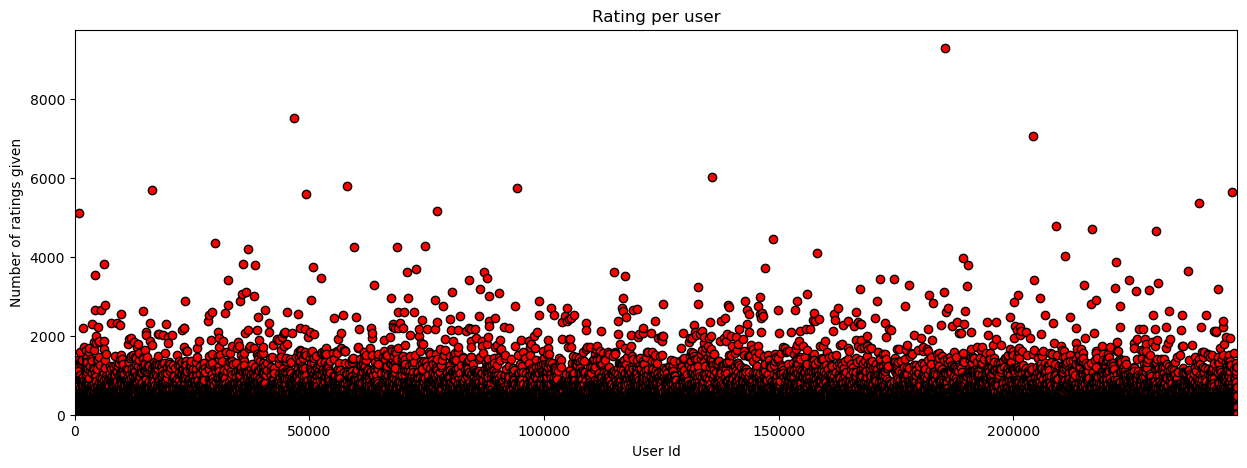

In [8]:
sample_df = ratings_df.groupby(["userId"]).count()
print("Minimum rating:", min(sample_df.movieId))
print("Mean rating:", sample_df.movieId.mean())
print("Maximum rating:", max(sample_df.movieId))
plt.figure(figsize= (15, 5))
plt.scatter(sample_df.index, sample_df.movieId, c= "red", edgecolors= "black")
plt.ylim(0,)
plt.xlim(0, len(sample_df.index))
plt.xlabel("User Id")
plt.ylabel("Number of ratings given")
plt.title("Rating per user")
plt.show()

From the histogram we can see the number of user ids that correspond to each number of ratings given.

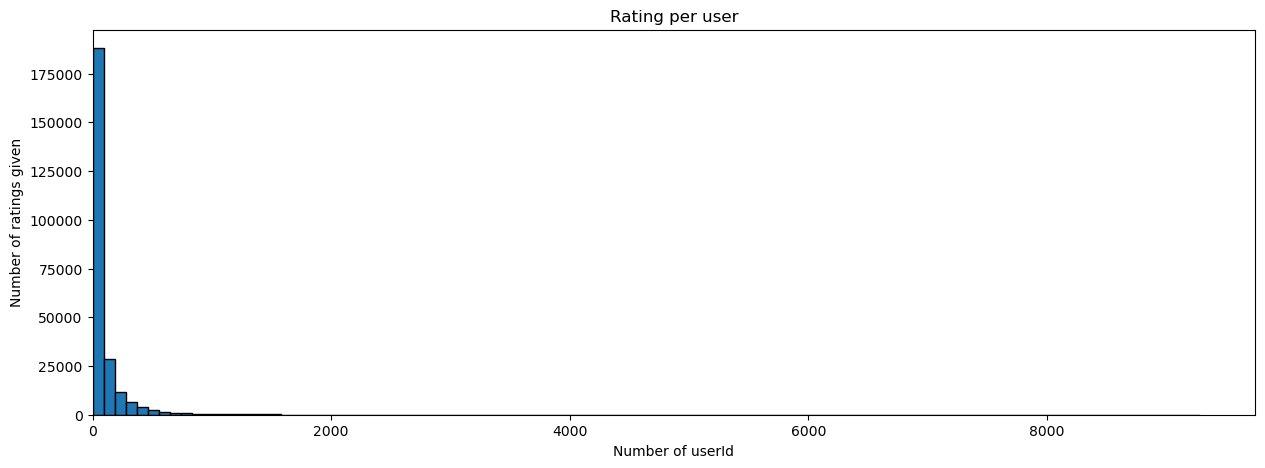

In [9]:
plt.figure(figsize= (15, 5))
plt.hist(sample_df.movieId, bins= 100, edgecolor= "black", log= False)
plt.xlabel("Number of userId")
plt.ylabel("Number of ratings given")
plt.title("Rating per user")
plt.xlim(0, )
plt.show()

As expected, we get an exponentially declining function, with some outliers with more than 4K ratings.

**Insight:** These graphs show us how much dedicated are the users to watching and rating movies.

### Rating per movie

Below we present the scatterplot and histogram of ratings number per movie.

From the scatterplot we can see the number of ratings received per movie id.

Minimum rating: 1
Mean rating: 679.6666765666765
Maximum rating: 81296


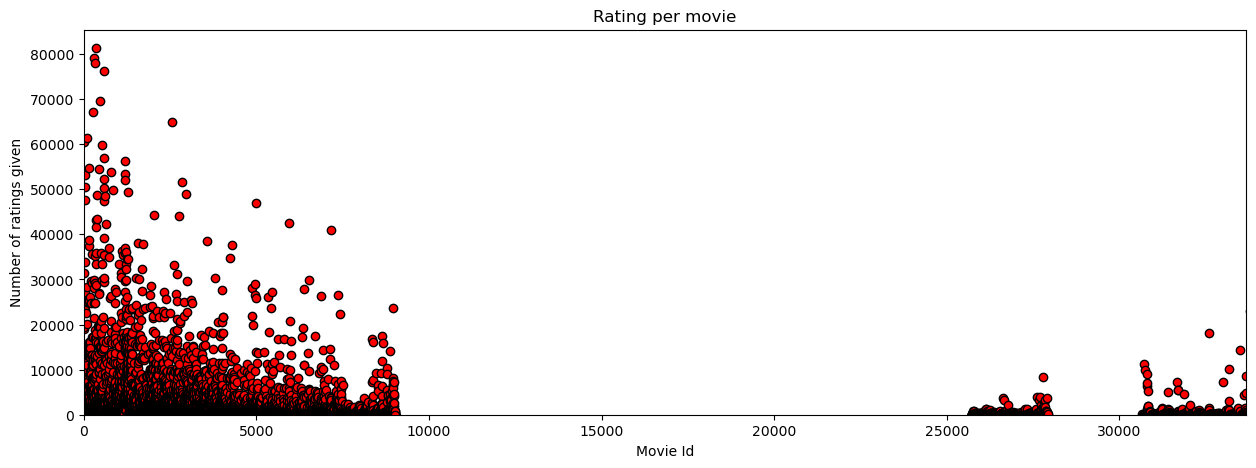

In [10]:
sample_df = ratings_df.groupby(["movieId"]).count()
print("Minimum rating:", min(sample_df.userId))
print("Mean rating:", sample_df.userId.mean())
print("Maximum rating:", max(sample_df.userId))
plt.figure(figsize= (15, 5))
plt.scatter(sample_df.index, sample_df.userId, c= "red", edgecolors= "black")
plt.ylim(0,)
plt.xlim(0, len(sample_df.index))
plt.xlabel("Movie Id")
plt.ylabel("Number of ratings given")
plt.title("Rating per movie")
plt.show()

From the histogram we can see the number of movie ids that correspond to each number of ratings received.

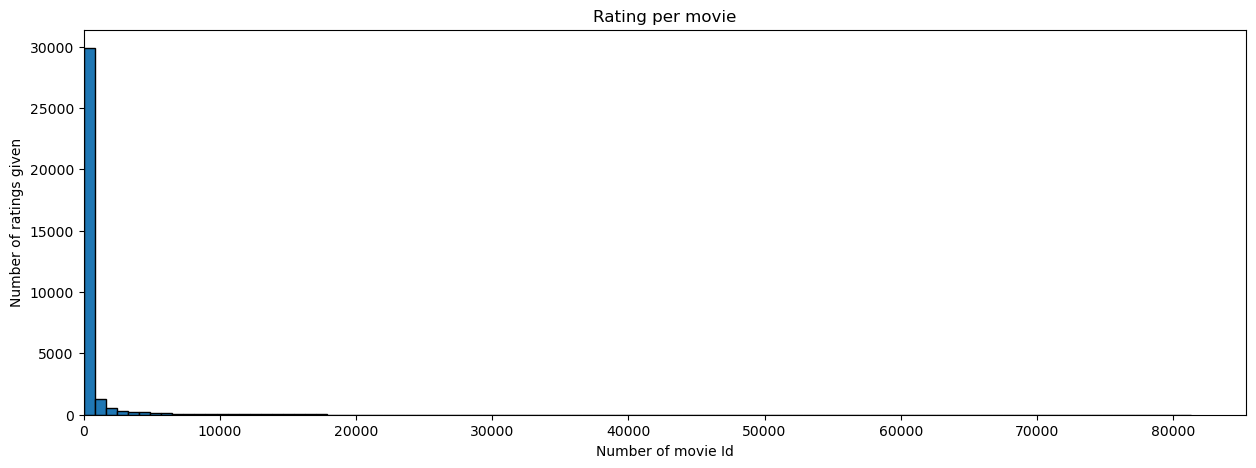

In [11]:
plt.figure(figsize= (15, 5))
plt.hist(sample_df.userId, bins= 100, edgecolor= "black", log= False)
plt.xlabel("Number of movie Id")
plt.ylabel("Number of ratings given")
plt.title("Rating per movie")
plt.xlim(0, )
plt.show()

From the above we can realize that most movies had a small number of ratings with a mean number of 679.66 ratings per movie. However, the scatterplot presented, also, some outliers over 5K ratings.

**Insight:** Not many users rate the same movies.

### Average rating per year

Let's show the average value of ratings variation in time.

First year of dataset 1995
Last year of datatset 2016


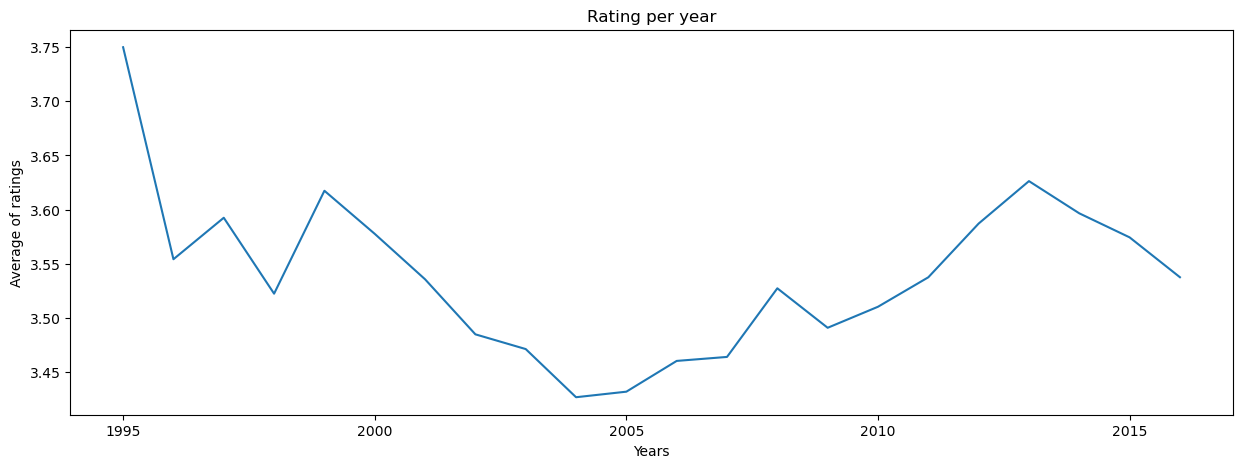

In [12]:
sample_df = ratings_df.copy()
sample_df.timestamp = sample_df.timestamp.dt.year
sample_df = sample_df.groupby("timestamp").mean()
print("First year of dataset", min(sample_df.index))
print("Last year of datatset", max(sample_df.index))
plt.figure(figsize= (15, 5))
plt.plot(sample_df.index, sample_df.rating)
plt.xlabel("Years")
plt.ylabel("Average of ratings")
plt.title("Rating per year")
plt.show()

We can say that between 2008 and 2004 the users were not giving big ratings to the movies they were watching.

### Popular movies

From the plot below we can find the 10 most popular movies. Movies with the maximum number of ratings and rating number.

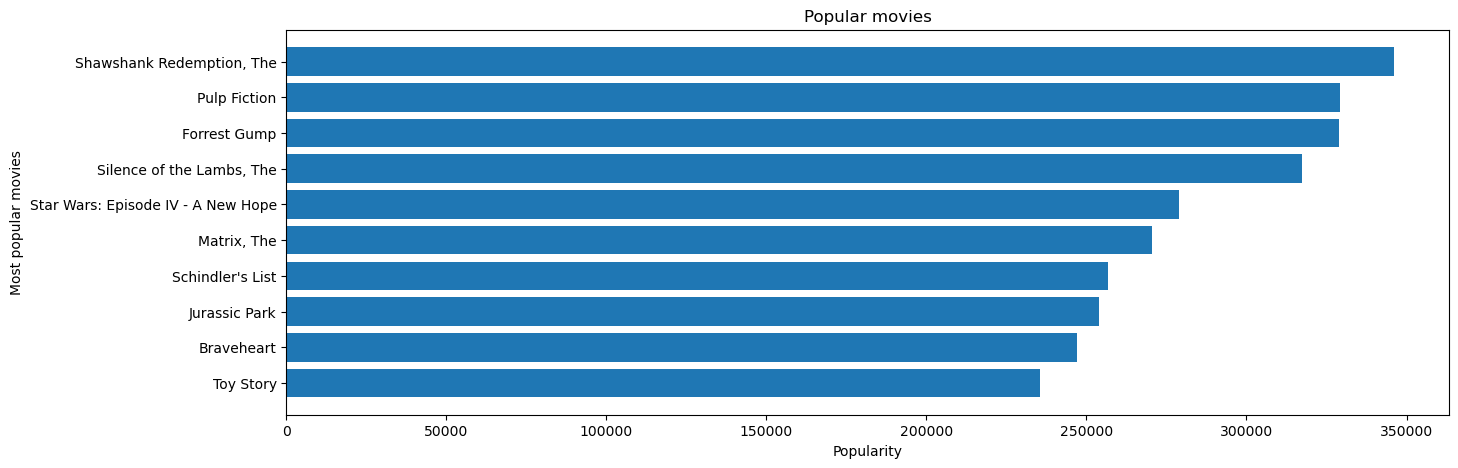

In [13]:
sample_df = movies_df.copy()
sample_df = ratings_df.merge(sample_df, left_on= "movieId", right_on= "movieId", how= "inner")
sample_df = sample_df.groupby(["title"]).sum().sort_values(by= "rating", ascending= False)
plt.figure(figsize= (15, 5))
plt.barh(sample_df.head(10).index, sample_df.head(10).rating, align= "center")
plt.gca().invert_yaxis()
plt.xlabel("Popularity")
plt.ylabel("Most popular movies")
plt.title("Popular movies")
plt.show()

### Most popular genres

We can also plot the most popular genre in terms of popularity points.

In [14]:
sample_df = movie_genres_distinct_df.copy()
sample_df = ratings_df.merge(sample_df, left_on= "movieId", right_on= "movieId", how= "inner")
sample_df

,userId,movieId,rating,timestamp,title,genres,year,Adventure,Animation,Children,...,Horror,Mystery,Sci-Fi,IMAX,Documentary,War,Musical,Western,Film-Noir,(no genres listed)
0,1,169,2.5,2008-03-08 01:38:14,Free Willy 2: The Adventure Home,"[Adventure, Children, Drama]",1995.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,13,169,1.0,2000-11-22 08:16:33,Free Willy 2: The Adventure Home,"[Adventure, Children, Drama]",1995.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,14,169,3.0,1996-10-16 16:22:01,Free Willy 2: The Adventure Home,"[Adventure, Children, Drama]",1995.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,17,169,1.0,1999-12-12 13:06:11,Free Willy 2: The Adventure Home,"[Adventure, Children, Drama]",1995.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,68,169,1.0,2002-01-15 14:24:04,Free Willy 2: The Adventure Home,"[Adventure, Children, Drama]",1995.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22884372,247509,95581,4.0,2012-07-07 07:44:11,"Flying Fleet, The","[Adventure, Drama, Romance]",1929.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
22884373,247534,111838,4.0,2015-04-14 18:28:33,"Man Named Rocca, A (Nommé La Rocca, Un) (Man C...",[Drama],1961.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
22884374,247662,137437,3.0,2015-07-08 04:30:28,Son of a Lion,[(no genres listed)],2007.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
22884375,247670,145939,5.0,2015-11-02 06:25:35,Sandesham,"[Children, Comedy]",1991.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [15]:
popularGenres = np.zeros_like(sample_df.columns[7:])
index = 0
for column in sample_df.columns[7:]:
    sub_df = sample_df[sample_df[column] == 1][[column, "rating"]].sum()
    popularGenres[index] = {"name": column, "rateSum": sub_df["rating"], "rateCount": sub_df[column], "rateMean":sub_df["rating"] / sub_df[column]}
    index += 1
popularGenres

array([{'name': 'Adventure', 'rateSum': 17934381.0, 'rateCount': 5117321.0, 'rateMean': 3.50464256590509},
       {'name': 'Animation', 'rateSum': 4923706.0, 'rateCount': 1362681.0, 'rateMean': 3.6132491757058327},
       {'name': 'Children', 'rateSum': 6558719.0, 'rateCount': 1923874.0, 'rateMean': 3.4091208675828044},
       {'name': 'Comedy', 'rateSum': 28837794.5, 'rateCount': 8437502.0, 'rateMean': 3.417811871333482},
       {'name': 'Fantasy', 'rateSum': 8581739.0, 'rateCount': 2449668.0, 'rateMean': 3.5032253350249913},
       {'name': 'Romance', 'rateSum': 15392444.0, 'rateCount': 4342070.0, 'rateMean': 3.544955286303537},
       {'name': 'Drama', 'rateSum': 37244822.5, 'rateCount': 10137200.0, 'rateMean': 3.6740739553328337},
       {'name': 'Action', 'rateSum': 22596793.0, 'rateCount': 6547286.0, 'rateMean': 3.4513221203411613},
       {'name': 'Crime', 'rateSum': 13986243.0, 'rateCount': 3803018.0, 'rateMean': 3.6776694193927035},
       {'name': 'Thriller', 'rateSum': 21500

In [16]:
popularGenres = pd.DataFrame([o for o in popularGenres])
popularGenres

,name,rateSum,rateCount,rateMean
0,Adventure,17934381.0,5117321.0,3.504643
1,Animation,4923706.0,1362681.0,3.613249
2,Children,6558719.0,1923874.0,3.409121
3,Comedy,28837794.5,8437502.0,3.417812
4,Fantasy,8581739.0,2449668.0,3.503225
5,Romance,15392444.0,4342070.0,3.544955
6,Drama,37244822.5,10137200.0,3.674074
7,Action,22596793.0,6547286.0,3.451322
8,Crime,13986243.0,3803018.0,3.677669
9,Thriller,21500137.0,6123348.0,3.511173


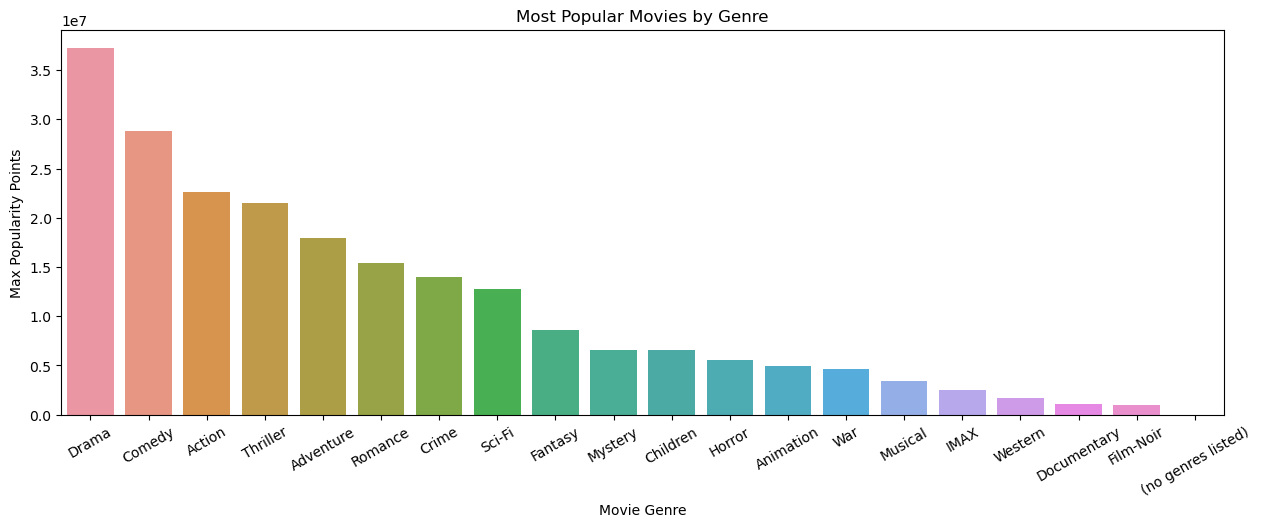

In [17]:
popularGenres.sort_values(by= "rateSum", ascending= False, inplace= True)
plt.figure(figsize= (15, 5))
ax = sns.barplot(x= popularGenres.name, y= popularGenres.rateSum)
x = ax.set_xlabel("Movie Genre")
b = ax.set_ylabel("Max Popularity Points")
c = ax.set_xticklabels(labels=ax.get_xticklabels(),rotation=30)
d = ax.set_title("Most Popular Movies by Genre")
plt.show()

**Conclusions:** The most popular movie genre in terms of popularity points is the "Darama" genre with 3.67 points and the least popular genre is the "No Genre Listed" one with 3.1 points.

### Average rate for each genre

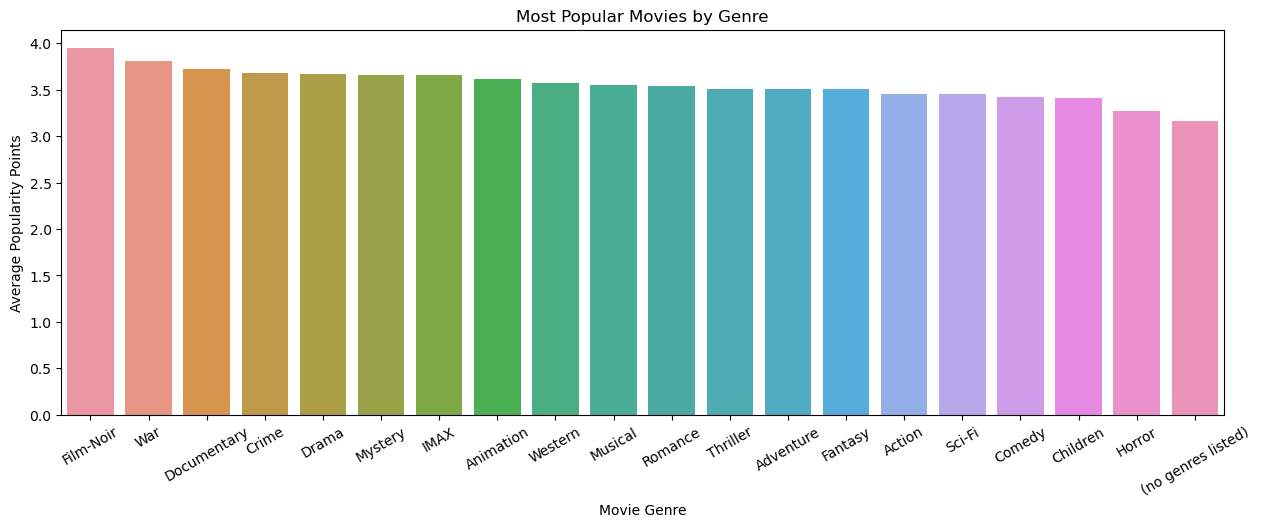

In [18]:
popularGenres.sort_values(by= "rateMean", ascending= False, inplace= True)
plt.figure(figsize= (15, 5))
ax = sns.barplot(x= popularGenres.name, y= popularGenres.rateMean)
x = ax.set_xlabel("Movie Genre")
b = ax.set_ylabel("Average Popularity Points")
c = ax.set_xticklabels(labels=ax.get_xticklabels(),rotation=30)
d = ax.set_title("Most Popular Movies by Genre")
plt.show()

**Conclusions:** The most popular movie genre in terms of popularity points is the "Darama" genre with 3.67 points and the least popular genre is the "No Genre Listed" one with 3.1 points.

## Get the sample input movies

In [60]:
userInput = [
            {'title': 'Jumanji', 'rating': 5, 'year': 1995},
            {'title': 'Spider-Man 2', 'rating': 3.5, 'year': 2004},
            {'title': 'Steve Jobs', 'rating': 5, 'year': 2015},
            {'title': "Mechanic, The", 'rating': 5, 'year': 2011},
            {'title': 'Intern, The', 'rating': 4.5, 'year': 2015}
         ] 
inputMovies = pd.DataFrame(userInput)
inputMovies

,title,rating,year
0,Jumanji,5.0,1995
1,Spider-Man 2,3.5,2004
2,Steve Jobs,5.0,2015
3,"Mechanic, The",5.0,2011
4,"Intern, The",4.5,2015


Find the movies from our dataset and merge together

In [62]:
filteredMovies = movie_genres_distinct_df[movie_genres_distinct_df.title.isin(inputMovies.title.tolist()) & movie_genres_distinct_df.year.isin(inputMovies.year.tolist())]
inputMovies = pd.merge(inputMovies, filteredMovies)
inputMovies

,title,rating,year,movieId,genres,Adventure,Animation,Children,Comedy,Fantasy,...,Horror,Mystery,Sci-Fi,IMAX,Documentary,War,Musical,Western,Film-Noir,(no genres listed)
0,Jumanji,5.0,1995,2,"[Adventure, Children, Fantasy]",1.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Spider-Man 2,3.5,2004,8636,"[Action, Adventure, Sci-Fi, IMAX]",1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Steve Jobs,5.0,2015,136562,[Drama],0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,"Mechanic, The",5.0,2011,85020,"[Action, Drama, Thriller]",0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,"Intern, The",4.5,2015,140110,[Comedy],0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


We do not need the Genres field

In [63]:
inputMovies.drop("genres", axis= 1, inplace= True)
inputMovies

,title,rating,year,movieId,Adventure,Animation,Children,Comedy,Fantasy,Romance,...,Horror,Mystery,Sci-Fi,IMAX,Documentary,War,Musical,Western,Film-Noir,(no genres listed)
0,Jumanji,5.0,1995,2,1.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Spider-Man 2,3.5,2004,8636,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Steve Jobs,5.0,2015,136562,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,"Mechanic, The",5.0,2011,85020,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,"Intern, The",4.5,2015,140110,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Content-Based Recommender

### Create user movies based on genres

For creating user profile, we just need the genres table

In [64]:
userMovies = inputMovies.drop("title", axis= 1).drop("rating", axis= 1).drop("movieId", axis= 1).drop("year", axis= 1)
userMovies

,Adventure,Animation,Children,Comedy,Fantasy,Romance,Drama,Action,Crime,Thriller,Horror,Mystery,Sci-Fi,IMAX,Documentary,War,Musical,Western,Film-Noir,(no genres listed)
0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Create user profile

For creating user profile, we just need to multiply user movies-genres to the input ratings

In [66]:
userProfile = userMovies.transpose().dot(inputMovies.rating)
userProfile.sort_values(ascending= False, inplace= True)
userProfile

Drama                 10.0
Adventure              8.5
Action                 8.5
Children               5.0
Fantasy                5.0
Thriller               5.0
Comedy                 4.5
Sci-Fi                 3.5
IMAX                   3.5
Documentary            0.0
Film-Noir              0.0
Western                0.0
Musical                0.0
War                    0.0
Horror                 0.0
Mystery                0.0
Animation              0.0
Crime                  0.0
Romance                0.0
(no genres listed)     0.0
dtype: float64

### Apply user profile on all the movies dataset

First, we have to extract all the genres to apply user profile on them

In [67]:
genreTable = movie_genres_distinct_df.set_index(movie_genres_distinct_df.movieId, inplace= True)
genreTable = movie_genres_distinct_df.drop("title", axis= 1).drop("genres", axis= 1).drop("movieId", axis= 1).drop("year", axis= 1)
genreTable

,Adventure,Animation,Children,Comedy,Fantasy,Romance,Drama,Action,Crime,Thriller,Horror,Mystery,Sci-Fi,IMAX,Documentary,War,Musical,Western,Film-Noir,(no genres listed)
movieId,,,,,,,,,,,,,,,,,,,,
1,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
151697,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
151701,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
151703,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Now, it's time to apply our user profile on all the movies dataset to find the best fit for the inputs

In [68]:
recommendationTable = (userProfile * genreTable).sum(axis= 1) / userProfile.sum()
recommendationTable.sort_values(ascending= False, inplace= True)
recommendationTable

movieId
117646    0.775701
144350    0.757009
71999     0.757009
149488    0.710280
41569     0.691589
            ...   
113911    0.000000
113908    0.000000
113906    0.000000
2637      0.000000
151711    0.000000
Length: 34208, dtype: float64

## Content-Based Result

In [69]:
recommendationTable = movies_df[movies_df.movieId.isin(recommendationTable.head(20).keys())]
recommendationTable = recommendationTable.sort_values(by= 'year', ascending= False)
recommendationTable

,movieId,title,genres,year
18347,91500,"Hunger Games, The","[Action, Adventure, Drama, Sci-Fi, Thriller]",2012.0
17537,88125,Harry Potter and the Deathly Hallows: Part 2,"[Action, Adventure, Drama, Fantasy, Mystery, I...",2011.0
16055,81132,Rubber,"[Action, Adventure, Comedy, Crime, Drama, Film...",2010.0
33509,148775,Wizards of Waverly Place: The Movie,"[Adventure, Children, Comedy, Drama, Fantasy, ...",2009.0
32313,144350,Under the Mountain,"[Action, Adventure, Children, Drama, Fantasy, ...",2009.0
33692,149488,Christmas Town,"[Action, Children, Comedy, Drama, Fantasy, Thr...",2008.0
12123,55116,"Hunting Party, The","[Action, Adventure, Comedy, Drama, Thriller]",2007.0
31687,142086,Fallen: The Beginning,"[Action, Adventure, Children, Drama, Fantasy]",2006.0
10654,41569,King Kong,"[Action, Adventure, Drama, Fantasy, Thriller]",2005.0
9459,27735,Unstoppable,"[Action, Adventure, Comedy, Drama, Thriller]",2004.0


## Collaborative-Based Recommender

We do not need the genres because this model works based on similarity to other users

In [74]:
inputMovies = inputMovies.iloc[:, 0:4]
inputMovies

,title,rating,year,movieId
0,Jumanji,5.0,1995,2
1,Spider-Man 2,3.5,2004,8636
2,Steve Jobs,5.0,2015,136562
3,"Mechanic, The",5.0,2011,85020
4,"Intern, The",4.5,2015,140110


### Find similar users

Find all users that rate at least one movies common with input movies

In [75]:
userSubset = ratings_df[ratings_df.movieId.isin(inputMovies.movieId.tolist())]
userSubset

,userId,movieId,rating,timestamp
314,10,8636,3.0,2005-01-05 22:48:51
479,13,2,2.0,2000-11-22 08:05:42
1248,17,2,3.0,1999-12-12 13:01:54
2841,23,8636,3.5,2013-09-09 01:47:18
3403,34,2,2.5,2004-06-03 16:56:01
...,...,...,...,...
22880772,247704,8636,3.0,2009-03-31 02:23:16
22881574,247710,8636,3.0,2007-03-21 23:40:04
22881937,247719,2,3.0,1996-10-26 12:42:49
22882871,247732,2,3.0,2012-06-30 21:16:57


Grouping all the filtered rating dataset with users, because users is important for us in this model

In [77]:
userSubsetGroup = userSubset.groupby(["userId"])

In [92]:
userSubsetGroup.agg(["count"]).movieId.sort_values(by= "count")

,count
userId,
10,1
155328,1
155324,1
155320,1
155312,1
...,...
36946,4
215174,4
85291,4


In [93]:
userSubsetGroup.get_group(85291)

,userId,movieId,rating,timestamp
7931674,85291,2,3.0,1999-11-02 21:23:51
7933016,85291,8636,4.5,2005-01-11 01:00:00
7933626,85291,85020,3.5,2012-03-06 03:55:52
7933844,85291,140110,4.5,2015-09-29 19:43:55


Sort the grouped dataset with the most common rating movies

In [95]:
userSubsetGroup = sorted(userSubsetGroup,  key=lambda x: len(x[1]), reverse=True)
userSubsetGroup[0:3]

[(4208,
          userId  movieId  rating           timestamp
  387005    4208        2     2.0 2004-02-15 11:50:25
  388683    4208     8636     3.5 2004-07-06 06:39:51
  389887    4208    85020     3.0 2011-03-12 22:01:12
  390495    4208   136562     3.0 2015-10-25 02:06:18),
 (6701,
          userId  movieId  rating           timestamp
  628512    6701        2     4.0 2016-01-23 22:01:45
  629397    6701     8636     3.5 2016-01-20 04:02:25
  629781    6701    85020     3.0 2016-01-23 04:12:06
  630021    6701   136562     2.5 2016-01-25 08:29:19),
 (14703,
           userId  movieId  rating           timestamp
  1374697   14703        2     3.5 2012-01-16 05:12:52
  1375344   14703     8636     4.0 2011-10-17 01:04:49
  1375647   14703    85020     2.5 2012-06-04 07:25:58
  1375819   14703   140110     4.0 2016-01-13 02:02:09)]

### Calculate the Pearson Correlation

First of all, we have to calculate the **Pearson Correlation** value for each user based on the common movies rating

In [105]:
inputMovies.sort_values(by= "movieId", inplace= True)
pearsonCorrelationDict = {}
for name, group in userSubsetGroup[0:100]:
    group.sort_values(by= "movieId", inplace= True)
    temp_df = inputMovies[inputMovies.movieId.isin(group.movieId.tolist())]
    rating_x = temp_df.rating.tolist()
    rating_y = group.rating.tolist()
    cor, p = pearsonr(rating_x, rating_y)
    pearsonCorrelationDict[name] = 0 if p is np.nan else p
pearsonCorrelationDict

/Users/sasan/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


{4208: 0.3377338214674781,
 6701: 0.741801110252839,
 14703: 0.33333333333333315,
 23534: 0,
 36946: 0.5285954792089683,
 49435: 0.5285954792089683,
 59853: 0.18350341907227385,
 61991: 0.5917517095361369,
 68765: 0.5285954792089683,
 85291: 0.21432579868161372,
 88296: 1.0,
 89367: 0.07282735005446939,
 105787: 0.5285954792089683,
 109990: 0.05719095841793653,
 112202: 0.26970325665977835,
 132751: 1.0,
 142943: 0.0853408792399527,
 157190: 0.6666666666666667,
 159795: 0.5285954792089684,
 168834: 0.5285954792089683,
 169491: 0.5006365374955046,
 181986: 0.5285954792089683,
 200936: 0.057190958417936755,
 212021: 0.507634036082669,
 215174: 0.2507313507346447,
 216540: 0.07417990022744858,
 234563: 0.057190958417936755,
 242021: 0.5917517095361369,
 244116: 0.13397459621556118,
 815: 0.3333333333333333,
 1573: 0.54562894834299,
 2404: 0.0,
 2569: 0.6666666666666666,
 2791: 0.0,
 3388: 0.6666666666666666,
 3817: 0.0,
 4663: 0,
 7278: 0.6666666666666666,
 7528: 0.5122457083554003,
 8863

Create Dataframe from the pearson correlation dict and change the index

In [112]:
pearsonDF = pd.DataFrame.from_dict(pearsonCorrelationDict, orient= "index")
pearsonDF.columns = ["similarityIndex"]
pearsonDF["userId"] = pearsonDF.index
pearsonDF.index = range(len(pearsonDF))
pearsonDF

,similarityIndex,userId
0,0.337734,4208
1,0.741801,6701
2,0.333333,14703
3,0.000000,23534
4,0.528595,36946
...,...,...
95,0.454371,51033
96,0.878962,51975
97,0.333333,52673
98,0.333333,53030


Sort the pearsonDF based on similarity and separate the fist 50 top users

In [117]:
pearsonDF.sort_values(by= "similarityIndex", ascending= False, inplace= True)
topUsers = pearsonDF[:50]
topUsers.head()

,similarityIndex,userId
55,1.000000,26987
86,1.000000,44066
15,1.000000,132751
10,1.000000,88296
67,0.926814,35265


### Find the other movies rated by top 50 users

In [118]:
topUserRating = topUsers.merge(ratings_df, left_on= "userId", right_on= "userId", how= "inner")
topUserRating

,similarityIndex,userId,movieId,rating,timestamp
0,1.000000,26987,1,5.0,2011-05-26 08:48:54
1,1.000000,26987,2,4.0,2011-05-26 09:15:57
2,1.000000,26987,6,3.0,2011-05-26 09:11:19
3,1.000000,26987,19,3.0,2011-05-26 09:16:36
4,1.000000,26987,32,4.0,2011-05-26 08:57:45
...,...,...,...,...,...
76405,0.528595,36946,144620,2.5,2015-12-12 18:51:55
76406,0.528595,36946,144760,2.0,2015-11-30 01:51:39
76407,0.528595,36946,147382,5.0,2015-11-21 22:53:37
76408,0.528595,36946,147384,5.0,2015-11-21 22:53:30


We have to calculate that how each rating affects on the final recommend based on the similarity

In [119]:
topUserRating["weightedRating"] = topUserRating.rating * topUserRating.similarityIndex
topUserRating

,similarityIndex,userId,movieId,rating,timestamp,weightedRating
0,1.000000,26987,1,5.0,2011-05-26 08:48:54,5.000000
1,1.000000,26987,2,4.0,2011-05-26 09:15:57,4.000000
2,1.000000,26987,6,3.0,2011-05-26 09:11:19,3.000000
3,1.000000,26987,19,3.0,2011-05-26 09:16:36,3.000000
4,1.000000,26987,32,4.0,2011-05-26 08:57:45,4.000000
...,...,...,...,...,...,...
76405,0.528595,36946,144620,2.5,2015-12-12 18:51:55,1.321489
76406,0.528595,36946,144760,2.0,2015-11-30 01:51:39,1.057191
76407,0.528595,36946,147382,5.0,2015-11-21 22:53:37,2.642977
76408,0.528595,36946,147384,5.0,2015-11-21 22:53:30,2.642977


In this step, we calculate and sum all the ratings affected by the similarity.
It gives us the most fit movies base on sum of the weighted rating, the maximum value of sum_weithedRating is the best match.

In [124]:
tempTopUserRating = topUserRating.groupby("movieId").sum()[["similarityIndex", "weightedRating"]]
tempTopUserRating.columns = ["sum_similarityIndex", "sum_weightedRating"]
tempTopUserRating

,sum_similarityIndex,sum_weightedRating
movieId,,
1,31.769914,123.444712
2,33.690420,110.855020
3,10.148675,24.739315
4,1.195262,1.861929
5,10.057410,28.154469
...,...,...
150674,0.787704,2.756965
150788,0.787704,3.150818
150995,0.787704,2.756965


Convert all the final recomment table to Dataframe

In [125]:
recommendation_df = pd.DataFrame()
recommendation_df["averageWeighted"] = tempTopUserRating.sum_weightedRating / tempTopUserRating.sum_similarityIndex
recommendation_df["movieId"] = tempTopUserRating.index
recommendation_df

,averageWeighted,movieId
movieId,,
1,3.885585,1
2,3.290402,2
3,2.437689,3
4,1.557758,4
5,2.799376,5
...,...,...
150674,3.500000,150674
150788,4.000000,150788
150995,3.500000,150995


In [127]:
recommendation_df.sort_values(by= "averageWeighted", ascending= False, inplace= True)
recommendation_df

,averageWeighted,movieId
movieId,,
65667,5.0,65667
79914,5.0,79914
123288,5.0,123288
30798,5.0,30798
140816,5.0,140816
...,...,...
46604,0.5,46604
6275,0.5,6275
4567,0.5,4567


## Collaborative-Based Result

In [130]:
recommendation_df = movies_df.loc[movies_df.movieId.isin(recommendation_df.head(20).movieId.tolist())].sort_values(by= "year", ascending= False)
recommendation_df

,movieId,title,genres,year
31276,140816,Tangerine,"[Comedy, Drama]",2015.0
31015,140160,Descendants,"[Action, Adventure, Comedy]",2015.0
30860,139655,Goodnight Mommy,"[Drama, Fantasy, Horror, Thriller]",2014.0
26771,124521,Squatters,[Drama],2014.0
30851,139636,The Blue Elephant,"[Drama, Horror, Mystery, Thriller]",2014.0
15748,79910,According to Greta,"[Drama, Romance]",2009.0
20315,99638,Fish Story (Fisshu sutôrî),[Comedy],2009.0
13085,62718,"Angus, Thongs and Perfect Snogging","[Comedy, Romance]",2008.0
15750,79914,Centre Stage: Turn It Up,"[Drama, Romance]",2008.0
13374,65667,Punk's Not Dead,[Documentary],2007.0


## Merge Both Models Result as a Hybrid Model

In [143]:
pd.concat([recommendation_df, recommendationTable]).sort_values(by= "year", ascending= False)

,movieId,title,genres,year
31276,140816,Tangerine,"[Comedy, Drama]",2015.0
31015,140160,Descendants,"[Action, Adventure, Comedy]",2015.0
30860,139655,Goodnight Mommy,"[Drama, Fantasy, Horror, Thriller]",2014.0
26771,124521,Squatters,[Drama],2014.0
30851,139636,The Blue Elephant,"[Drama, Horror, Mystery, Thriller]",2014.0
18347,91500,"Hunger Games, The","[Action, Adventure, Drama, Sci-Fi, Thriller]",2012.0
17537,88125,Harry Potter and the Deathly Hallows: Part 2,"[Action, Adventure, Drama, Fantasy, Mystery, I...",2011.0
16055,81132,Rubber,"[Action, Adventure, Comedy, Crime, Drama, Film...",2010.0
20315,99638,Fish Story (Fisshu sutôrî),[Comedy],2009.0
15748,79910,According to Greta,"[Drama, Romance]",2009.0
